In [273]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import quantecon as qe
import requests
import string

In [274]:
"""
Prereqs:
    - Download Snapshot vote reports either manually or using snapshot_report_download.py script
    - Download the token's hodler distribution from Etherscan:
        - for INDEX token, Download CSV link at https://etherscan.io/token/0x0954906da0Bf32d5479e25f46056d22f08464cab#balances
        - this could not be automated as Etherscan requires recaptcha. Could be automated with a graph or etherscan pro API call
    - Install python dependencies listed above
"""

"\nPrereqs:\n    - Download Snapshot vote reports either manually or using snapshot_report_download.py script\n    - Download the token's hodler distribution from Etherscan:\n        - for INDEX token, Download CSV link at https://etherscan.io/token/0x0954906da0Bf32d5479e25f46056d22f08464cab#balances\n        - this could not be automated as Etherscan requires recaptcha. Could be automated with a graph or etherscan pro API call\n    - Install python dependencies listed above\n"

In [275]:
# Parameters: Substitute with the values of the project and Snapshot vote you want to analyze
# Running analsysis for all Index Coop Decision Gate 2 votes
vote_urls = {
    'BTC2X-FLI': 'https://snapshot.org/#/index/proposal/Qmc2DPHoKnyYxRjQfwbpbBngt5xHZrLBgkywGqZm7hHnEU',
    'SMI': 'https://snapshot.org/#/index/proposal/QmYBG5zerdSkC9TGwguy5biCS5h2cg49PQCHCukJqHmfE1',
    'TTI': 'https://snapshot.org/#/index/proposal/QmTPVkgfJBB1go2DCFhmacjgSWrLUzTFimdTGdB7d9Q2ao',
    'MVI': 'https://snapshot.org/#/index/proposal/QmadsabYMJC96jU2S2kPCSh1suVfDVApGLwrux2WwsHd7x',
    'ETH2X-FLI2': 'https://snapshot.org/#/index/proposal/QmYHV2vdTaSubtNJefSoYx82ypsmtzrT7CGUU1EHsXzHC3',
    'ETH2X-FLI1': 'https://snapshot.org/#/index/proposal/QmQwQn4k324kMKPjsSX6ZEzjkkKWh1DNfAN2mQ3dd5aP1a'
}
proposal_ids = [url.split('/')[-1] for url in vote_urls.values()]
local_download_folder_path = 'C:/Users/craig/Downloads/'
etherscan_token_hodler_csv_path = 'etherscan_index_hodler_table.csv'

# Remove treasury, vesting and DEX LP wallets. Manually entered from https://etherscan.io/token/0x0954906da0Bf32d5479e25f46056d22f08464cab#balances
wallet_addresses_to_exclude = [
    '0xd89c642e52bd9c72bcc0778bcf4de307cc48e75a',
    '0xf64d061106054fe63b0aca68916266182e77e9bc',
    '0x26e316f5b3819264df013ccf47989fb8c891b088',
    '0x9467cfadc9de245010df95ec6a585a506a8ad5fc',
    '0xe2250424378b6a6dc912f5714cfd308a8d593986',
    '0x71f2b246f270c6af49e2e514ca9f362b491fbbe1',
    '0x4c11dfd35a4fe079b41d5d9729ed34c00d487712',
    '0x66a7d781828b03ee1ae678cd3fe2d595ba3b6000',
    '0x0d627ca04a97219f182dab0dc2a23fb4a5b02a9d',
    '0x5c29aa6761803bcfda7f683eaa0ff9bddda3649d',
    '0xce3c6312385fcf233ab0de574b0cb1a588566c3f',
    '0xb93b505ed567982e2b6756177ddd23ab5745f309',
    '0xdd111f0fc07f4d89ed6ff96dbab19a61450b8435',
    '0x0f58793e8cf39d6b60919ffaf773a7f95a568146',
    '0xa73df646512c82550c2b3c0324c4eedee53b400c',
    '0xcf19a7c81fcf0e01c927f28a2b551405e58c77e5',
    '0x3452a7f30a712e415a0674c0341d44ee9d9786f9',
    '0x674bdf20a0f284d710bc40872100128e2d66bd3f',
    '0x8f06fba4684b5e0988f215a47775bb611af0f986',
    '0x673d140eed36385cb784e279f8759f495c97cf03'
]

# Enter the quorum threshold for the project, get current circulating supply from CoinGecko
# Warning: this provides approximate results based on current outstanding supply and therefore may not be accurate for
#          projects with high inflation that deviates from supply during historical votes. Historical supply could be fed
#          with database queries or historically accurate wallet balance CSV files
coin_gecko_response = requests.get('https://api.coingecko.com/api/v3/coins/index-cooperative?tickers=true&market_data=true').json()
circulating_supply = coin_gecko_response['market_data']['circulating_supply']
quorum_threshold = 0.15
yes_vote_threshold = 0.6
votes_needed_for_quorum = round(quorum_threshold * circulating_supply, 2)
etherscan_token_hodler_csv_path = 'etherscan_index_hodler_table.csv'

In [276]:
def compute_gini(series_label:str, series_np_array:np.array):
    gini = qe.gini_coefficient(series_np_array)
    print(f'{series_label} Gini Coefficient: {gini}')

    # Plot Lorenz curve
    equality_curve, lorenz_curve = qe.lorenz_curve(series_np_array)
    fig, ax = plt.subplots()
    ax.plot(equality_curve, lorenz_curve, label=f'Lorenz curve of {series_label}')
    ax.plot(equality_curve, equality_curve, label='Lorenz curve, equality')
    ax.legend()
    plt.show()

The minimum number of (all) hodlers needed to pass an initiative is: 4
The minimum number of (low balance) hodlers needed to pass an initiative if no one of higher rank participates is: 2923 / 3027
Global Wealth Gini Coefficient (2019): 0.885, source: https://en.wikipedia.org/wiki/List_of_countries_by_wealth_inequality
All INDEX wallet balances Gini Coefficient: 0.9345398060618589


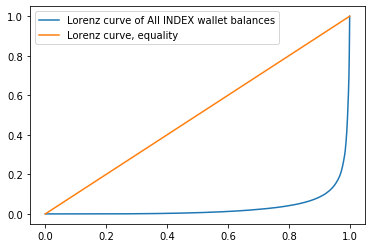

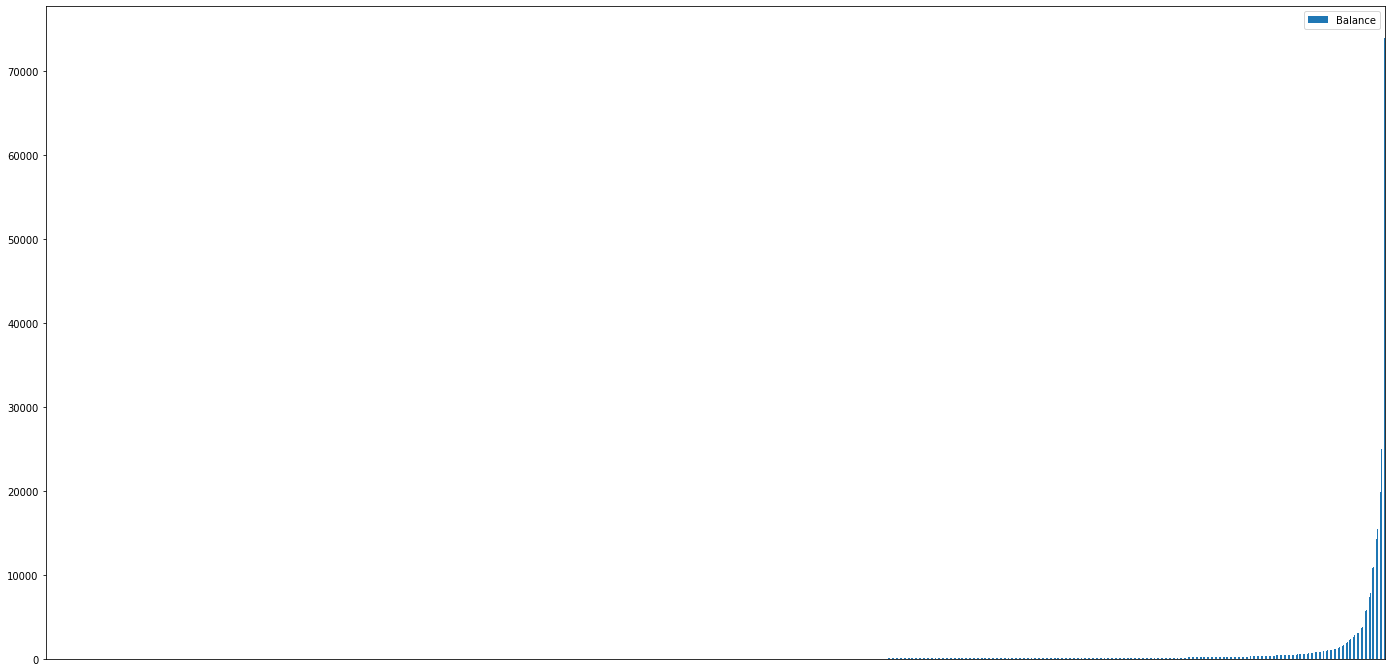

In [277]:
# Read Etherscan.io hodler wallet balance csv file
index_hodlers_with_treasury = pd.read_csv(etherscan_token_hodler_csv_path)
index_hodler_df = index_hodlers_with_treasury.loc[~index_hodlers_with_treasury.HolderAddress.isin(wallet_addresses_to_exclude)]
index_hodler_df = index_hodler_df.sort_values('Balance', ascending=False)
index_hodler_df['cumulative_dist'] = index_hodler_df['Balance'].cumsum()
index_hodler_df.index = range(len(index_hodler_df))
index_hodler_df.Balance.describe()
wallet_balance_sum = index_hodler_df['Balance'].sum()
theoretical_minimum_number_of_voters_needed = min(index_hodler_df.index[index_hodler_df['cumulative_dist'] > votes_needed_for_quorum]) + 1
print(f'The minimum number of (all) hodlers needed to pass an initiative is: {theoretical_minimum_number_of_voters_needed}')
theoretical_minimum_number_of_low_balance_voters =  len(index_hodler_df) - max(index_hodler_df.index[(wallet_balance_sum-index_hodler_df['cumulative_dist']) > votes_needed_for_quorum])
print(f'The minimum number of (low balance) hodlers needed to pass an initiative if no one of higher rank participates is: {theoretical_minimum_number_of_low_balance_voters} / {len(index_hodler_df)}')
print(f'Global Wealth Gini Coefficient (2019): 0.885, source: https://en.wikipedia.org/wiki/List_of_countries_by_wealth_inequality')
hodler_balance_array = index_hodler_df['Balance'].to_numpy()
compute_gini('All INDEX wallet balances', hodler_balance_array)
index_hodler_df.sort_values('Balance').plot.bar(y='Balance', figsize=(24,12)).xaxis.set_visible(False)

In [278]:
index_hodler_df

,HolderAddress,Balance,PendingBalanceUpdate,cumulative_dist
0,0x4a3e950c35c6d9c2d8f5f0a6cc03af9942134840,7.402667e+04,No,7.402667e+04
1,0x4ec7cdf61405758f5ced5e454c0b4b0f4f043df0,6.856936e+04,No,1.425960e+05
2,0xcfc50541c3deaf725ce738ef87ace2ad778ba0c5,5.000000e+04,No,1.925960e+05
3,0x2dd8de7cfe9d34a1d03311a6231154c107af8c88,4.313156e+04,No,2.357276e+05
4,0xfe48d2fdaf5c2447d7e39c5b12ac4e49d1f6a0e7,4.289967e+04,No,2.786273e+05
...,...,...,...,...
3022,0x0000000008c9f3e47c663451c87dc7ae4d029c9b,1.000000e-18,No,1.168046e+06
3023,0x00000000cd47aa64daf64f5144b0d7885754374c,1.000000e-18,No,1.168046e+06
3024,0x000000000000084e91743124a982076c59f10084,1.000000e-18,No,1.168046e+06
3025,0x000000005804b22091aa9830e50459a15e7c9241,1.000000e-18,No,1.168046e+06


In [279]:
index_hodler_df.loc[index_hodler_df['Balance'] > 1]

,HolderAddress,Balance,PendingBalanceUpdate,cumulative_dist
0,0x4a3e950c35c6d9c2d8f5f0a6cc03af9942134840,74026.673494,No,7.402667e+04
1,0x4ec7cdf61405758f5ced5e454c0b4b0f4f043df0,68569.359573,No,1.425960e+05
2,0xcfc50541c3deaf725ce738ef87ace2ad778ba0c5,50000.000089,No,1.925960e+05
3,0x2dd8de7cfe9d34a1d03311a6231154c107af8c88,43131.564261,No,2.357276e+05
4,0xfe48d2fdaf5c2447d7e39c5b12ac4e49d1f6a0e7,42899.666241,No,2.786273e+05
...,...,...,...,...
2466,0xfccb964c514c12794509ed62fa274f0e284cee82,1.016876,No,1.167878e+06
2467,0xc16414ac1fedfdac4f8a09674d994e1bbb9d7113,1.010000,No,1.167879e+06
2468,0x2606cb984b962ad4aa1ef00f9af9b654b435ad44,1.000553,No,1.167880e+06
2469,0xca9ba74ee20917211ef646ac51accc287f27538b,1.000428,No,1.167881e+06


In [280]:
index_hodler_df['percent_of_voting_supply'] = (index_hodler_df['cumulative_dist']/index_hodler_df['Balance'].sum()) * 100
index_hodler_df['percentile'] = (index_hodler_df.index/len(index_hodler_df)) * 100
index_hodler_df['HolderAddress'] = index_hodler_df['HolderAddress'].astype(str)
number_of_wallets_in_threshold = [min(index_hodler_df.index[index_hodler_df['percentile'] > percentile]) for percentile in top_hodler_percentile_thresholds]
max_percentile_thresholds = [0.1, 1.0, 10.0, 100.0]
percentile_members = dict()
for i in range(0, len(max_percentile_thresholds)):
    percentile = max_percentile_thresholds[i]
    prior_percentile_range_max = max_percentile_thresholds[i-1] if i > 0 else 0.0
    percentile_range = f'{str(prior_percentile_range_max)}-{max_percentile_thresholds[i]}%'
    total_n_members =  len(index_hodler_df.loc[index_hodler_df['percentile'] < percentile])
    range_member_df = index_hodler_df.loc[(index_hodler_df['percentile'] < percentile) & (index_hodler_df['percentile'] >= prior_percentile_range_max)]
    range_n_members = len(range_member_df)
    member_list = range_member_df.HolderAddress.tolist()
    percentile_members[percentile_range] = {
        'percentile_val': percentile,
        'total_n_members': total_n_members,
        'range_n_members': range_n_members,
        'member_list': member_list
    }
voter_df = pd.DataFrame()
voter_df['address'] = index_hodler_df['HolderAddress']

In [281]:
analysis_results = dict()
def run_vote_analysis(vote_key:str):
    analysis_results[vote_key] = dict()
    vote_url = vote_urls[vote_key]
    proposal_id = vote_url.split('/')[-1]
    vote_df = pd.read_csv(f'{local_download_folder_path}snapshot-report-{proposal_id}.csv')
    vote_df['address'] = vote_df.address.str.lower()
    vote_df = vote_df.sort_values('balance', ascending=False)
    vote_df['cumulative_dist'] = vote_df['balance'].cumsum()
    vote_df.index = range(len(vote_df))
    votes_for = round(vote_df.loc[vote_df['choice'] == 1, 'balance'].sum(), 2)
    voters_for = round(vote_df.loc[vote_df['choice'] == 1, 'choice'].sum(), 2)
    votes_against = round(vote_df.loc[vote_df['choice'] == 2, 'balance'].sum(), 2)
    voters_against = len(vote_df.loc[vote_df['choice'] == 2, 'choice'])
    print(f'Votes for: {votes_for}, Votes against: {votes_against}')
    prop_in_favor = (float(votes_for)/(votes_for + votes_against))
    print(f'Percent in favor: {round(prop_in_favor*100, 2)}%')
    print(f'Unique voters (wallets) for: {voters_for}, Unique voters (wallets) against: {voters_against}')
    print(f'Did the vote exceed the quorum threshold? {"Yes" if votes_for > votes_needed_for_quorum else "No"}')
    lowest_rank_balance_needed_to_pass = np.nan
    if votes_for > votes_needed_for_quorum and prop_in_favor > yes_vote_threshold:
        succeeded = 1
        print(f'This initiative succeeded. {votes_for} votes in favor > {votes_needed_for_quorum} votes needed to meet quorum')
        minimum_number_of_voters_needed = min(vote_df.index[vote_df['cumulative_dist'] > votes_needed_for_quorum]) + 1
        print(f'The minimum number of voting hodlers needed to pass this initiative was: {minimum_number_of_voters_needed}')
    else:
        succeeded = 0
        print(f'This initiative failed. {votes_for} votes in favor < {votes_needed_for_quorum} votes needed to meet quorum')
        votes_short_by = round(votes_needed_for_quorum - votes_for, 2)
        print(f'The minimum number of additional votes needed to pass was {votes_short_by}')
        if index_hodler_df['Balance'].max() > votes_short_by:
            lowest_rank_balance_needed_to_pass =  min(index_hodler_df.index[index_hodler_df['Balance'] > votes_short_by]) + 1
            print(f'This means the initiative could have passed if any wallet with balance ranked in the top {lowest_rank_balance_needed_to_pass} had voted')
    voter_balance_array = vote_df['balance'].to_numpy()
    compute_gini('All INDEX voter balances', voter_balance_array)
    vote_df.plot.bar(y='balance', figsize=(24,8)).xaxis.set_visible(False)
    if votes_for > votes_needed_for_quorum:
        quorum_threshold_index = min(vote_df.index[vote_df['cumulative_dist'] > votes_needed_for_quorum])
        plt.axvline(x=quorum_threshold_index, color='red')
    # Percent of top .1, 1 and 10% hodlers voting in initiative
    voter_addresses = vote_df['address'].tolist()
    analysis_results[vote_key] = {
        'votes_for': votes_for,
        'voters_for': voters_for,
        'votes_against': votes_against,
        'voters_against': voters_against,
        'prop_in_favor': prop_in_favor,
        'succeeded': succeeded,
        'votes_short_by': votes_short_by if not succeeded else 0,
        'minimum_number_of_voters_needed': minimum_number_of_voters_needed if succeeded else np.nan,
        'lowest_rank_balance_needed_to_pass': lowest_rank_balance_needed_to_pass,
    }
    for key, val in percentile_members.items():
        range_members_voted = len([member for member in val['member_list'] if member in voter_addresses])
        print(f'{range_members_voted} out of {val["range_n_members"]} members in the {key} range voted in this initiative')
        percent_voting = float(range_members_voted)/val['range_n_members'] * 100
        print(f'{round(percent_voting, 2)}% of wallets in {key} range voted in this initiative')
        analysis_results[vote_key][f'percent_{key}_voted'] = round(percent_voting, 2)
    voter_df[vote_key] = voter_df['address'].isin(voter_addresses)

Votes for: 344272.58, Votes against: 0.0
Percent in favor: 100.0%
Unique voters (wallets) for: 123, Unique voters (wallets) against: 0
Did the vote exceed the quorum threshold? Yes
This initiative succeeded. 344272.58 votes in favor > 215904.3 votes needed to meet quorum
The minimum number of voting hodlers needed to pass this initiative was: 5
All INDEX voter balances Gini Coefficient: 0.899783364889563


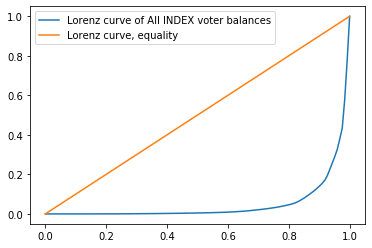

3 out of 4 members in the 0.0-0.1% range voted in this initiative
75.0% of wallets in 0.0-0.1% range voted in this initiative
6 out of 27 members in the 0.1-1.0% range voted in this initiative
22.22% of wallets in 0.1-1.0% range voted in this initiative
34 out of 272 members in the 1.0-10.0% range voted in this initiative
12.5% of wallets in 1.0-10.0% range voted in this initiative
71 out of 2724 members in the 10.0-100.0% range voted in this initiative
2.61% of wallets in 10.0-100.0% range voted in this initiative


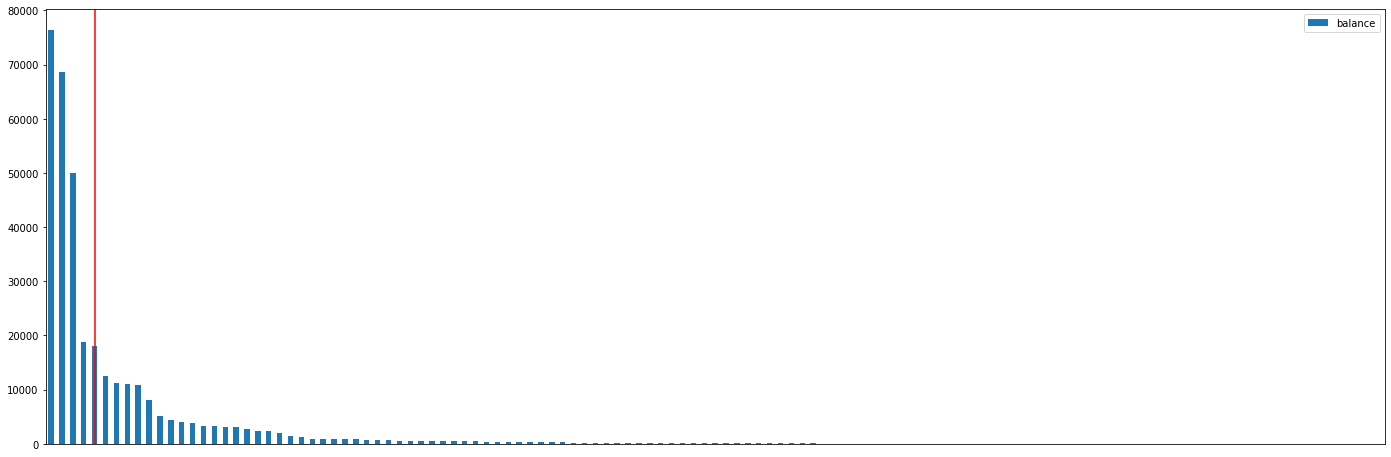

In [282]:
run_vote_analysis('BTC2X-FLI')

Votes for: 262434.99, Votes against: 0.0
Percent in favor: 100.0%
Unique voters (wallets) for: 149, Unique voters (wallets) against: 0
Did the vote exceed the quorum threshold? Yes
This initiative succeeded. 262434.99 votes in favor > 215904.3 votes needed to meet quorum
The minimum number of voting hodlers needed to pass this initiative was: 15
All INDEX voter balances Gini Coefficient: 0.8882854586745768


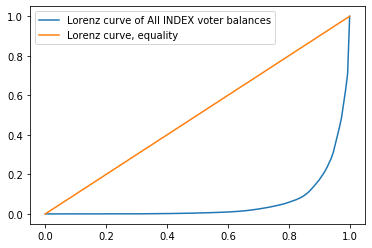

1 out of 4 members in the 0.0-0.1% range voted in this initiative
25.0% of wallets in 0.0-0.1% range voted in this initiative
7 out of 27 members in the 0.1-1.0% range voted in this initiative
25.93% of wallets in 0.1-1.0% range voted in this initiative
40 out of 272 members in the 1.0-10.0% range voted in this initiative
14.71% of wallets in 1.0-10.0% range voted in this initiative
91 out of 2724 members in the 10.0-100.0% range voted in this initiative
3.34% of wallets in 10.0-100.0% range voted in this initiative


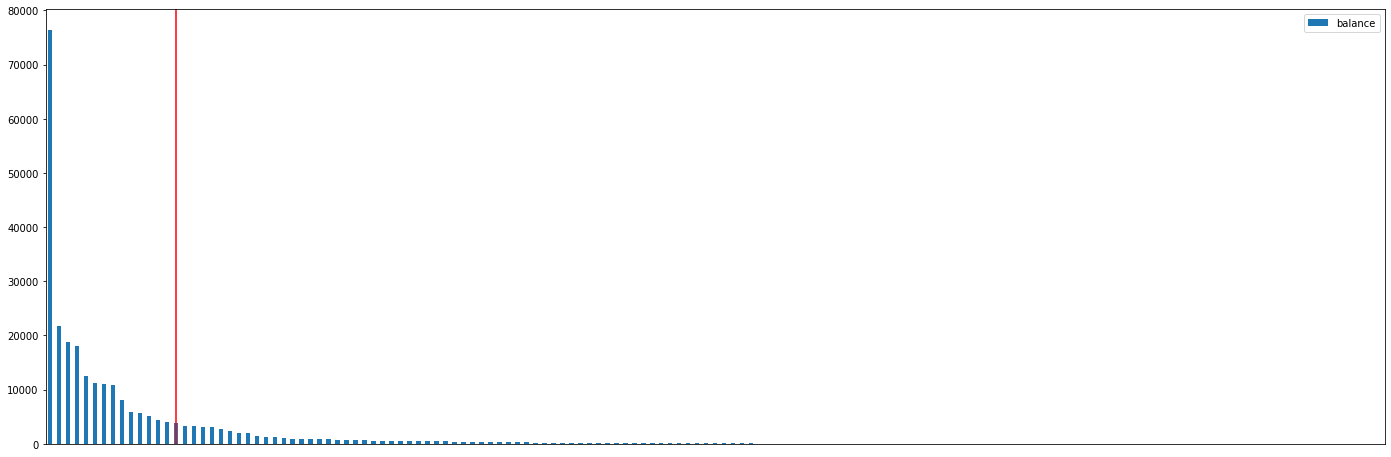

In [283]:
run_vote_analysis('SMI')

Votes for: 42334.52, Votes against: 2721.16
Percent in favor: 93.96%
Unique voters (wallets) for: 115, Unique voters (wallets) against: 4
Did the vote exceed the quorum threshold? No
This initiative failed. 42334.52 votes in favor < 215904.3 votes needed to meet quorum
The minimum number of additional votes needed to pass was 173569.78
All INDEX voter balances Gini Coefficient: 0.8058077711130683


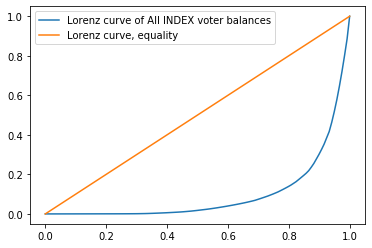

0 out of 4 members in the 0.0-0.1% range voted in this initiative
0.0% of wallets in 0.0-0.1% range voted in this initiative
0 out of 27 members in the 0.1-1.0% range voted in this initiative
0.0% of wallets in 0.1-1.0% range voted in this initiative
23 out of 272 members in the 1.0-10.0% range voted in this initiative
8.46% of wallets in 1.0-10.0% range voted in this initiative
87 out of 2724 members in the 10.0-100.0% range voted in this initiative
3.19% of wallets in 10.0-100.0% range voted in this initiative


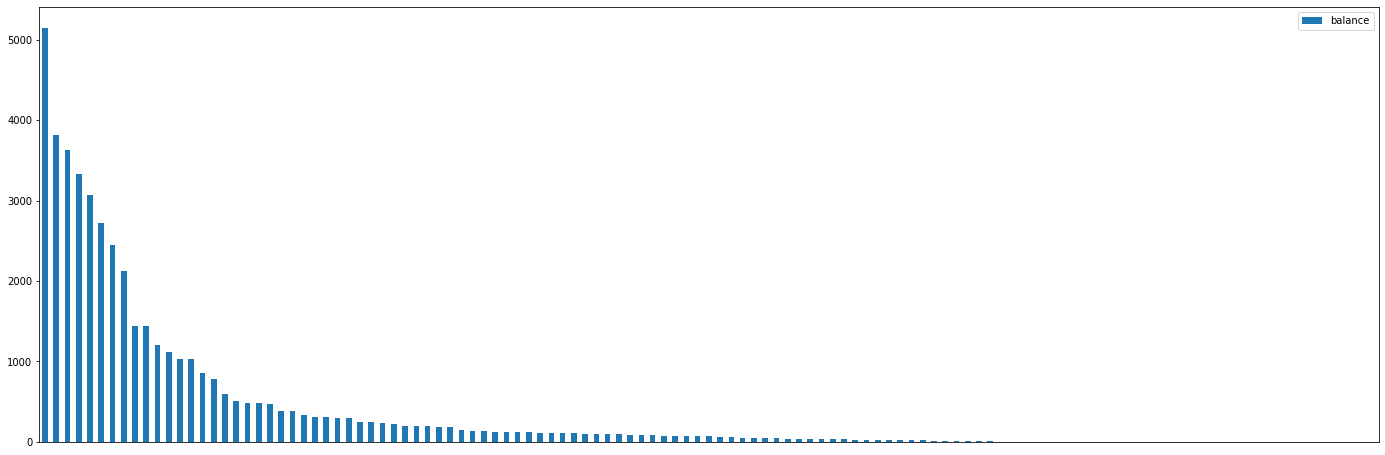

In [284]:
run_vote_analysis('TTI')

Votes for: 246119.08, Votes against: 0.0
Percent in favor: 100.0%
Unique voters (wallets) for: 153, Unique voters (wallets) against: 0
Did the vote exceed the quorum threshold? Yes
This initiative succeeded. 246119.08 votes in favor > 215904.3 votes needed to meet quorum
The minimum number of voting hodlers needed to pass this initiative was: 20
All INDEX voter balances Gini Coefficient: 0.8835600874784805


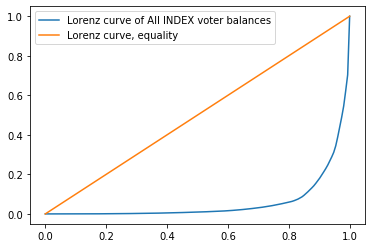

1 out of 4 members in the 0.0-0.1% range voted in this initiative
25.0% of wallets in 0.0-0.1% range voted in this initiative
5 out of 27 members in the 0.1-1.0% range voted in this initiative
18.52% of wallets in 0.1-1.0% range voted in this initiative
38 out of 272 members in the 1.0-10.0% range voted in this initiative
13.97% of wallets in 1.0-10.0% range voted in this initiative
95 out of 2724 members in the 10.0-100.0% range voted in this initiative
3.49% of wallets in 10.0-100.0% range voted in this initiative


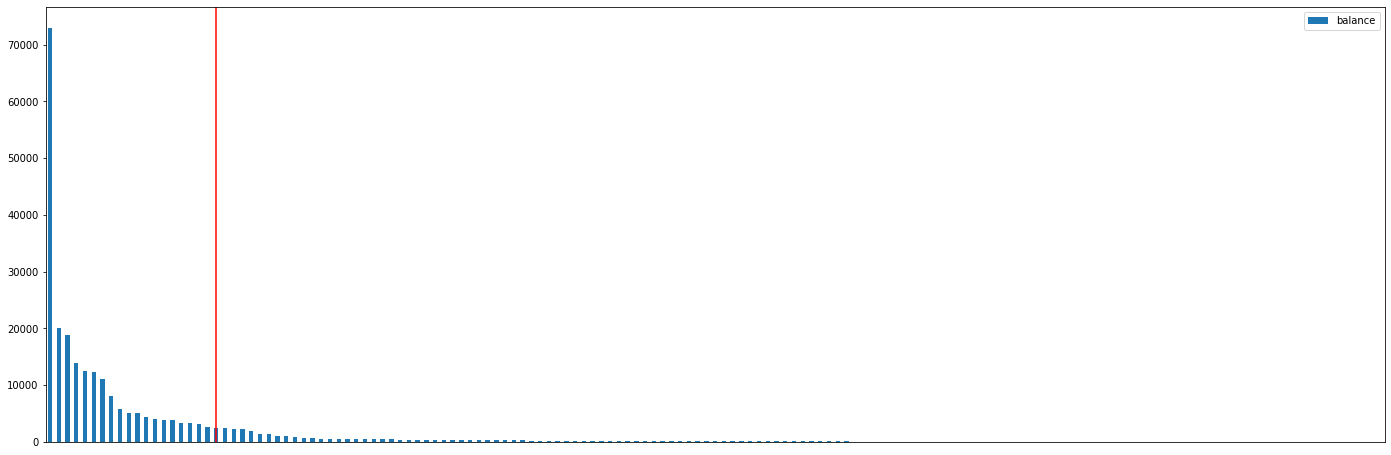

In [285]:
run_vote_analysis('MVI')

Votes for: 323936.34, Votes against: 321.19
Percent in favor: 99.9%
Unique voters (wallets) for: 115, Unique voters (wallets) against: 1
Did the vote exceed the quorum threshold? Yes
This initiative succeeded. 323936.34 votes in favor > 215904.3 votes needed to meet quorum
The minimum number of voting hodlers needed to pass this initiative was: 5
All INDEX voter balances Gini Coefficient: 0.9014330237828367


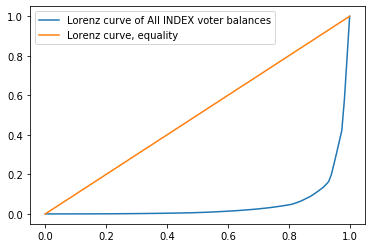

3 out of 4 members in the 0.0-0.1% range voted in this initiative
75.0% of wallets in 0.0-0.1% range voted in this initiative
4 out of 27 members in the 0.1-1.0% range voted in this initiative
14.81% of wallets in 0.1-1.0% range voted in this initiative
28 out of 272 members in the 1.0-10.0% range voted in this initiative
10.29% of wallets in 1.0-10.0% range voted in this initiative
51 out of 2724 members in the 10.0-100.0% range voted in this initiative
1.87% of wallets in 10.0-100.0% range voted in this initiative


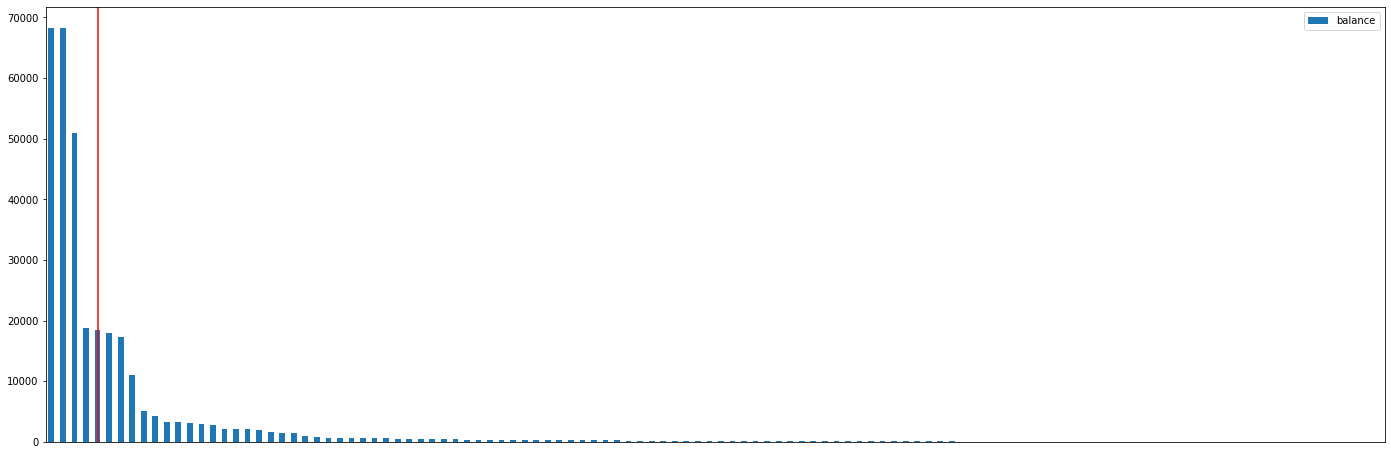

In [286]:
run_vote_analysis('ETH2X-FLI2')

Votes for: 75532.24, Votes against: 0.0
Percent in favor: 100.0%
Unique voters (wallets) for: 70, Unique voters (wallets) against: 0
Did the vote exceed the quorum threshold? No
This initiative failed. 75532.24 votes in favor < 215904.3 votes needed to meet quorum
The minimum number of additional votes needed to pass was 140372.06
All INDEX voter balances Gini Coefficient: 0.8431664106381022


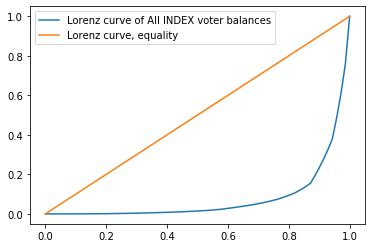

0 out of 4 members in the 0.0-0.1% range voted in this initiative
0.0% of wallets in 0.0-0.1% range voted in this initiative
3 out of 27 members in the 0.1-1.0% range voted in this initiative
11.11% of wallets in 0.1-1.0% range voted in this initiative
12 out of 272 members in the 1.0-10.0% range voted in this initiative
4.41% of wallets in 1.0-10.0% range voted in this initiative
30 out of 2724 members in the 10.0-100.0% range voted in this initiative
1.1% of wallets in 10.0-100.0% range voted in this initiative


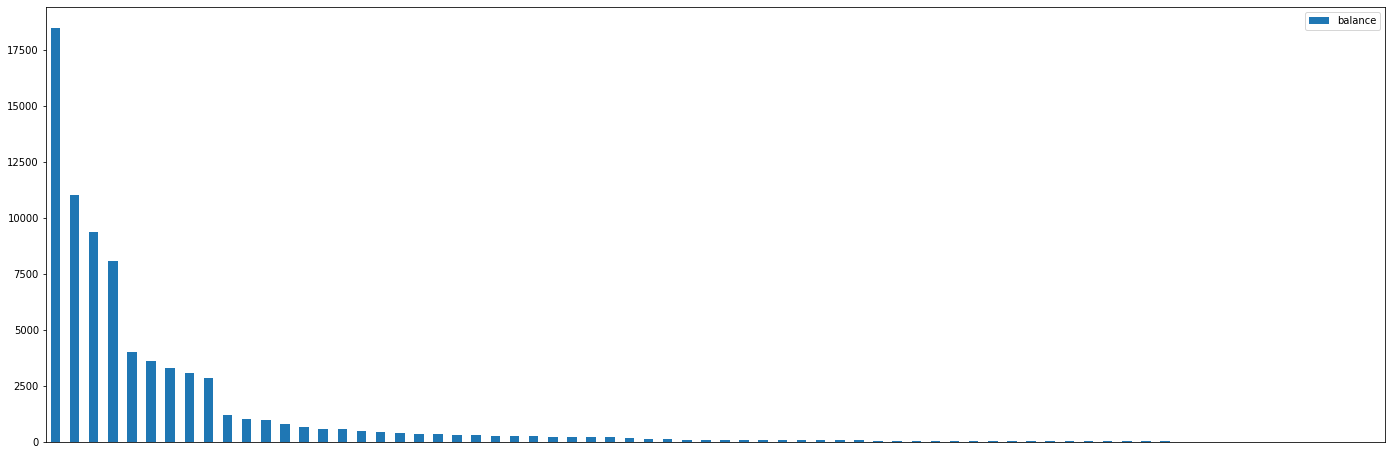

In [287]:
run_vote_analysis('ETH2X-FLI1')

In [288]:
# Voted in n initiatives
voter_df['num_votes'] = voter_df.select_dtypes(include=['bool']).sum(axis=1)
voted_at_least_once = len(voter_df.loc[voter_df["num_votes"]>=1])
percent_voted_at_least_once = round(100*voted_at_least_once/len(voter_df), 2)
print(f'Number of holders who have voted on at least 1 initiative: {voted_at_least_once} / {len(voter_df)} ({percent_voted_at_least_once}%)')
print('Vote count distribution: \n'+ str(voter_df.num_votes.value_counts()))

Number of holders who have voted on at least 1 initiative: 306 / 3027 (10.11%)
Vote count distribution: 
0    2721
1     140
2      89
3      27
4      26
5      14
6      10
Name: num_votes, dtype: int64


Text(0, 0.5, 'Number of wallets')

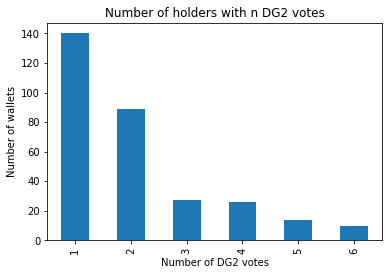

In [302]:
pd.DataFrame(voter_df.num_votes.value_counts()).loc[1:6, 'num_votes'].plot.bar()
plt.title("Number of holders with n DG2 votes")
plt.xlabel("Number of DG2 votes")
plt.ylabel("Number of wallets")

In [289]:
# Overall initiative comparison
analysis_results_df = pd.DataFrame(analysis_results)
analysis_results_df

,BTC2X-FLI,SMI,TTI,MVI,ETH2X-FLI2,ETH2X-FLI1
votes_for,344272.58,262434.99,42334.520000,246119.08,323936.340000,75532.24
voters_for,123.00,149.00,115.000000,153.00,115.000000,70.00
votes_against,0.00,0.00,2721.160000,0.00,321.190000,0.00
voters_against,0.00,0.00,4.000000,0.00,1.000000,0.00
prop_in_favor,1.00,1.00,0.939605,1.00,0.999009,1.00
succeeded,1.00,1.00,0.000000,1.00,1.000000,0.00
votes_short_by,0.00,0.00,173569.780000,0.00,0.000000,140372.06
minimum_number_of_voters_needed,5.00,15.00,NaN,20.00,5.000000,NaN
lowest_rank_balance_needed_to_pass,NaN,NaN,NaN,NaN,NaN,NaN
percent_0.0-0.1%_voted,75.00,25.00,0.000000,25.00,75.000000,0.00


In [290]:
analysis_results_transposed = analysis_results_df.transpose()
analysis_results_transposed

,votes_for,voters_for,votes_against,voters_against,prop_in_favor,succeeded,votes_short_by,minimum_number_of_voters_needed,lowest_rank_balance_needed_to_pass,percent_0.0-0.1%_voted,percent_0.1-1.0%_voted,percent_1.0-10.0%_voted,percent_10.0-100.0%_voted
BTC2X-FLI,344272.58,123.0,0.00,0.0,1.000000,1.0,0.00,5.0,NaN,75.0,22.22,12.50,2.61
SMI,262434.99,149.0,0.00,0.0,1.000000,1.0,0.00,15.0,NaN,25.0,25.93,14.71,3.34
TTI,42334.52,115.0,2721.16,4.0,0.939605,0.0,173569.78,NaN,NaN,0.0,0.00,8.46,3.19
MVI,246119.08,153.0,0.00,0.0,1.000000,1.0,0.00,20.0,NaN,25.0,18.52,13.97,3.49
ETH2X-FLI2,323936.34,115.0,321.19,1.0,0.999009,1.0,0.00,5.0,NaN,75.0,14.81,10.29,1.87
ETH2X-FLI1,75532.24,70.0,0.00,0.0,1.000000,0.0,140372.06,NaN,NaN,0.0,11.11,4.41,1.10


In [291]:
descriptives = analysis_results_df.apply(pd.Series.describe, axis=1)
descriptives

,count,mean,std,min,25%,50%,75%,max
votes_for,6.0,215771.625000,127324.823315,42334.520000,118178.950000,254277.035,308561.0025,344272.58
voters_for,6.0,120.833333,29.949402,70.000000,115.000000,119.000,142.5000,153.00
votes_against,6.0,507.058333,1092.266070,0.000000,0.000000,0.000,240.8925,2721.16
voters_against,6.0,0.833333,1.602082,0.000000,0.000000,0.000,0.7500,4.00
prop_in_favor,6.0,0.989769,0.024579,0.939605,0.999257,1.000,1.0000,1.00
succeeded,6.0,0.666667,0.516398,0.000000,0.250000,1.000,1.0000,1.00
votes_short_by,6.0,52323.640000,81736.410419,0.000000,0.000000,0.000,105279.0450,173569.78
minimum_number_of_voters_needed,4.0,11.250000,7.500000,5.000000,5.000000,10.000,16.2500,20.00
lowest_rank_balance_needed_to_pass,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
percent_0.0-0.1%_voted,6.0,33.333333,34.156503,0.000000,6.250000,25.000,62.5000,75.00


Text(0, 0.5, 'Percent voting')

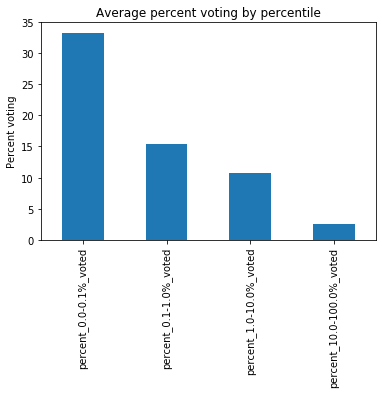

In [292]:
descriptives['percent_0.0-0.1%_voted':]['mean'].plot.bar()
plt.title('Average percent voting by percentile')
plt.ylabel('Percent voting')

Text(0, 0.5, 'Minimum number of voters needed to meet quorum')

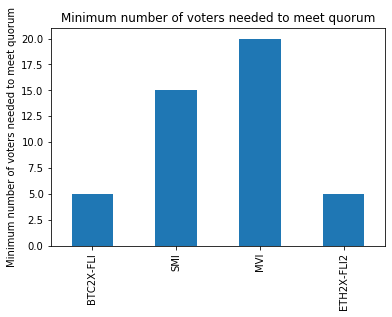

In [293]:
analysis_results_transposed.loc[analysis_results_transposed['succeeded']==1, 'minimum_number_of_voters_needed'].plot.bar()
plt.title('Minimum number of voters needed to meet quorum')
plt.ylabel('Minimum number of voters needed to meet quorum')